In [22]:
# !pip install --upgrade pandas
!pip install h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from pickle import load,dump
import os
%matplotlib inline

In [0]:
df =pd.read_pickle("privacy_optout_policy.pkl")


In [3]:
df.head(1)

,doc_type,file,text,year
0,pp,/Users/dbm/Downloads/OPP-115/sanitized_policie...,Privacy Policy Last Modified March 25 2013 Thi...,2013


In [4]:
df = df.drop(['file', 'year'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 2 columns):
doc_type    229 non-null object
text        229 non-null object
dtypes: object(2)
memory usage: 3.7+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Number of pp and oo docs')

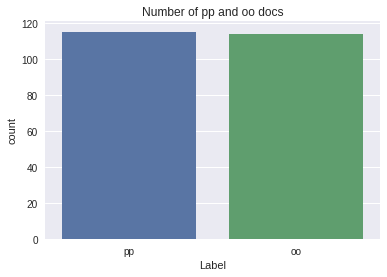

In [5]:
sns.countplot(df.doc_type)
plt.xlabel('Label')
plt.title('Number of pp and oo docs')


In [0]:
X = df.text
Y = df.doc_type
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [8]:
[for i in X]

LabelEncoder()

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15, random_state = 0)


In [0]:
max_words = 20000
max_len = 2000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [0]:
# Define RNN structure
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [12]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 2000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 50)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)  

In [14]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=100,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 155 samples, validate on 39 samples
Epoch 1/100
155/155 [==============================] - 5s 32ms/step - loss: 0.3152 - acc: 0.9290 - val_loss: 0.5252 - val_acc: 0.8205
Epoch 2/100
155/155 [==============================] - 5s 32ms/step - loss: 0.2720 - acc: 0.9355 - val_loss: 0.5896 - val_acc: 0.6667


In [0]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [16]:
accr = model.evaluate(test_sequences_matrix,Y_test)

35/35 [==============================] - 0s 10ms/step


In [17]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.611
  Accuracy: 0.629


In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("classification_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("classification_model.h5")
print("Saved model to disk")

Saved model to disk


In [24]:
# later...
from keras.models import model_from_json

# load json and create model
json_file = open('classification_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("classification_model.h5")
print("Loaded model from disk")


Loaded model from disk


##### References
- https://www.kaggle.com/kredy10/simple-lstm-for-text-classification
- https://machinelearningmastery.com/save-load-keras-deep-learning-models/